In [5]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
import chromedriver_binary
from bs4 import BeautifulSoup
from credential import *
import json
import time
import pandas as pd
import re
import requests
import os
from IPython.display import display, HTML, Image
from tqdm.auto import tqdm
from copy import copy


options = webdriver.ChromeOptions()
options.add_argument("--headless=new")
options.add_argument("--window-size=1920,5400")

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36 Edg/117.0.2045.60",
}

folder_prefix = "springer-10.1007"

In [18]:
def to_institute(url):
    protocol, domain_and_path = url.split("://")
    domain, path = domain_and_path.split("/", 1)
    institute_domain = domain.replace(".", "-")
    institute_url = f"{protocol}://{institute_domain}.proxy.lib.ohio-state.edu/{path}"
    return institute_url


def to_normal(url):
    protocol, domain_and_path = url.split("://")
    domain, path = domain_and_path.split("/", 1)
    normal_domain = domain.replace(".proxy.lib.ohio-state.edu", "").replace("-", ".")
    normal_url = f"{protocol}://{normal_domain}/{path}"
    return normal_url


def maintext_formatter(article):
    for i in article.find_all("h2"):
        i.string = "\n\n" + i.text + ":\n"
    for i in article.find_all("h3"):
        i.string = "\n\n" + i.text + ":\n"
    for i in article.find_all("p"):
        i.append(" ")
    return re.sub(r"^ +", "", article.text, flags=re.MULTILINE).strip()

In [19]:
metadata_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQ6zCX7UhgM9Q7O9gp8IaAFwOfotCT7_jSbJc8ab0IY-Pmnf1fNOpVwnAG-Jn_WVdP1XKRHntDxHIBU/pub?gid=101839528&single=true&output=csv"
df_meta = pd.read_csv(metadata_url)

In [20]:
springer_list = df_meta[
    df_meta.isPaper & df_meta.hasHtml & (df_meta.platform == "Springer")
].doi.tolist()
# springer_list

In [21]:
driver = webdriver.Chrome(options=options)
errors = []
processed = []

for doi in tqdm(springer_list):
    if doi in processed:
        continue

    paper_id = doi.split("/")[-1]
    os.makedirs(f"{folder_prefix}/{paper_id}", exist_ok=True)
    url = f"https://doi-org.proxy.lib.ohio-state.edu/{doi}"

    driver.get(url)
    try:
        WebDriverWait(driver, timeout=10).until(
            lambda d: "Login Required" in d.page_source
            or d.find_element(By.CLASS_NAME, "main-content").is_displayed()
        )
    except Exception as e:
        errors.append((f"{url}: Invalid URL", e, driver.get_screenshot_as_png()))
        continue
    if "Login Required" in driver.page_source:
        print(f"OSU proxy login required.")
        username_element = driver.find_element(By.ID, "username")
        password_element = driver.find_element(By.ID, "password")
        username_element.send_keys(osu_username)
        password_element.send_keys(osu_passwd)
        login_button = driver.find_element(By.ID, "submit")
        login_button.click()
        print(f"OSU proxy login success.")
    try:
        WebDriverWait(driver, timeout=10).until(
            lambda d: d.find_element(By.CLASS_NAME, "main-content").is_displayed()
        )
    except Exception as e:
        errors.append((f"{url}: Article not found", e, driver.get_screenshot_as_png()))
        continue

    soup = BeautifulSoup(driver.page_source, "html.parser")
    with open(f"{folder_prefix}/{paper_id}/webpage.html", "w") as f:
        f.write(soup.prettify())
    meta_match = re.search(r"window.dataLayer ?= ?(\[.*?\]);", str(soup))
    if meta_match:
        meta = json.loads(meta_match.group(1))
        with open(f"{folder_prefix}/{paper_id}/meta.json", "w") as f:
            json.dump(meta, f, indent=4)
    else:
        errors.append((f"{url}: No metadata found"), driver.get_screenshot_as_png())

    try:
        abstract = soup.find("section", {"data-title": "Abstract"}).find("p").text
        with open(f"{folder_prefix}/{paper_id}/abstract.txt", "w") as f:
            f.write(abstract)
    except Exception as e:
        errors.append((f"{url}: No abstract found"), e, driver.get_screenshot_as_png())

    article = soup.find("div", {"class": "main-content"})

    figures = article.find_all("div", {"data-container-section": "figure"})
    for fig in figures:
        img_url = to_normal(
            "https:" + re.sub(r"(?<=/)lw\d{3,4}(?=/)", "full", fig.find("img")["src"])
        )
        img_name = img_url.split("/")[-1]
        imgb = requests.get(img_url, headers=headers).content
        fig_id = fig["id"].replace("ure-", "")
        with open(f"{folder_prefix}/{paper_id}/{fig_id}-{img_name}", "wb") as f:
            f.write(imgb)
        if fig.find("p"):
            fig_caption = fig.find("p").text
            with open(f"{folder_prefix}/{paper_id}/{fig_id}-caption.txt", "w") as f:
                f.write(fig_caption)
            fig.find("div", {"class": "u-text-right u-hide-print"}).extract()

    tables = article.find_all("div", {"data-container-section": "table"})
    for tab in tables:
        tab_id = tab["id"].replace("-", "")
        tab_url = (
            "https://link.springer.com"
            + tab.find("a", {"data-test": "table-link"})["href"]
        )
        driver.get(tab_url)
        try:
            WebDriverWait(driver, timeout=10).until(
                lambda d: d.find_element(
                    By.CLASS_NAME, "c-article-table-container"
                ).is_displayed()
            )
            tab_soup = BeautifulSoup(driver.page_source, "html.parser")
            if len(driver.find_elements(By.CLASS_NAME, "data.last-table")) > 0:
                tab_source = tab_soup.find("table", {"class": "data last-table"})
                with open(f"{folder_prefix}/{paper_id}/{tab_id}-source.html", "w") as f:
                    f.write(tab_source.prettify())
                tab_element = driver.find_element(
                    By.CLASS_NAME, "c-article-table-border.c-table-scroll-wrapper"
                )
                driver.execute_script("arguments[0].scrollIntoView(true);", tab_element)
                tab_element.screenshot(
                    f"{folder_prefix}/{paper_id}/{tab_id}-screenshot.png"
                )
            elif len(driver.find_elements(By.CLASS_NAME, "c-article-table-image")):
                tab_img_url = to_normal(
                    "https:"
                    + re.sub(
                        r"(?<=/)lw\d{3,4}(?=/)",
                        "full",
                        tab_soup.find("div", {"class": "c-article-table-image"}).find(
                            "img"
                        )["src"],
                    )
                )
                tab_imgb = requests.get(tab_img_url, headers=headers).content
                with open(
                    f"{folder_prefix}/{paper_id}/{tab_id}-screenshot.png", "wb"
                ) as f:
                    f.write(tab_imgb)
            else:
                errors.append(
                    (
                        f"{tab_url}: Unrecognized table structure",
                        e,
                        driver.get_screenshot_as_png(),
                    )
                )
            tab_caption = tab.find("b").text
            with open(f"{folder_prefix}/{paper_id}/{tab_id}-caption.txt", "w") as f:
                f.write(tab_caption)
            tab.find("div", {"class": "u-text-right u-hide-print"}).extract()
        except Exception as e:
            errors.append(
                (
                    f"{tab_url}: Can't access table url",
                    e,
                    driver.get_screenshot_as_png(),
                )
            )

    with open(f"{folder_prefix}/{paper_id}/maintext.txt", "w") as f:
        f.write(maintext_formatter(article))

    processed.append(doi)

driver.close()
print(f"Scraped {len(processed)} papers")
print(f"Errors: {len(errors)}")
for l, e, s in errors:
    print(l)
    # print(e)
    display(Image(s))
    time.sleep(0.1)

  0%|          | 0/24 [00:00<?, ?it/s]

OSU proxy login required.
OSU proxy login success.
Scraped 24 papers
Errors: 0


In [12]:
import requests

headers = {
    'authority': 'www.science.org',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'accept-language': 'en-US,en;q=0.9,zh-CN;q=0.8,zh;q=0.7',
    'cache-control': 'max-age=0',
    'cookie': 'MAID=3Y6fRqYXzDv8AtreI0nU3g==; AMCVS_242B6472541199F70A4C98A6%40AdobeOrg=1; adBlockEnabled=not%20blocked; s_ecid=MCMID%7C52650840160635178913202690420508369967; _fbp=fb.1.1697081186737.1313212032; s_cc=true; weby_location_cookie={"location_requires_cookie_consent":"false","location_requires_cookie_paywall":"false","int":"92eafac5-0b33-434c-a621-c4734e380ee8"}; _gcl_au=1.1.1080673640.1697081188; __qca=P0-1570815081-1697081188015; _ga=GA1.1.1395357231.1698000198; GA1.2.1395357231.1698000198; cookiePolicy=iaccept; JSESSIONID=00e355e4-4c90-4ea8-9c47-c578e940007e; MACHINE_LAST_SEEN=2023-10-26T06%3A46%3A26.875-07%3A00; __cf_bm=8Ru2VtNe4nEqE0zDUpWQT_5D73dkywTsUZksIaWP3NM-1698327986-0-AVdzAitfjRVTgio2Kd0nVaAd8F1IyL8O2tZmjGy2sCdimasZGh6asTMnRe0SPNqv5ihQFVooEWbo/GfL/Tq/mew=; AMCV_242B6472541199F70A4C98A6%40AdobeOrg=179643557%7CMCIDTS%7C19656%7CMCMID%7C52650840160635178913202690420508369967%7CMCAAMLH-1698932789%7C7%7CMCAAMB-1698932789%7CRKhpRz8krg2tLO6pguXWp5olkAcUniQYPHaMWWgdJ3xzPWQmdj0y%7CMCOPTOUT-1698335189s%7CNONE%7CMCAID%7CNONE%7CvVersion%7C5.5.0; cf_clearance=W9DZg3.MpyCJGwgZchDhwcli6tkNfcbrRSfhwIaNlGI-1698327990-0-1-72cef427.be76b494.94bdb5ed-0.2.1698327990; __gads=ID=f09eeabc5ad290ac:T=1697081187:RT=1698327990:S=ALNI_Ma66sxk0ia4xHqsfI7zIPgHWBLqDg; __gpi=UID=00000d98e09c5b75:T=1697081187:RT=1698327990:S=ALNI_MYB7YQSAYu9hPwfCkVBMqP3idBtHg; _uetsid=81e19160738611ee84ce0fb69f1dddc9; _uetvid=20bbb48068af11eeb0218b858259ce18; _ga_KQG7WRFJWG=GS1.1.1698327997.3.0.1698327997.0.0.0; _gid=GA1.2.184120707.1698327998; s_tp=4736; s_ppv=www.science.org%2Fdoi%2F10.1126%2Fscience.aar6170%2C38%2C38%2C1788.3333129882812; s_plt=3.04; s_pltp=www.science.org%2Fdoi%2F10.1126%2Fscience.aar6170',
    'sec-ch-ua': '"Chromium";v="118", "Google Chrome";v="118", "Not=A?Brand";v="99"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'document',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-site': 'none',
    'sec-fetch-user': '?1',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36',
}

response = requests.get(
    'https://www.science.org/cms/10.1126/science.aay2400/asset/d52d6613-5878-42d7-9de8-d9506f0fbde9/assets/graphic/365_885_f1.jpeg',
    headers=headers,
)
response

<Response [403]>

In [6]:
driver = webdriver.Chrome(options=options)

In [13]:
driver.get('https://www.science.org/cms/10.1126/science.aay2400/asset/d52d6613-5878-42d7-9de8-d9506f0fbde9/assets/graphic/365_885_f1.jpeg')

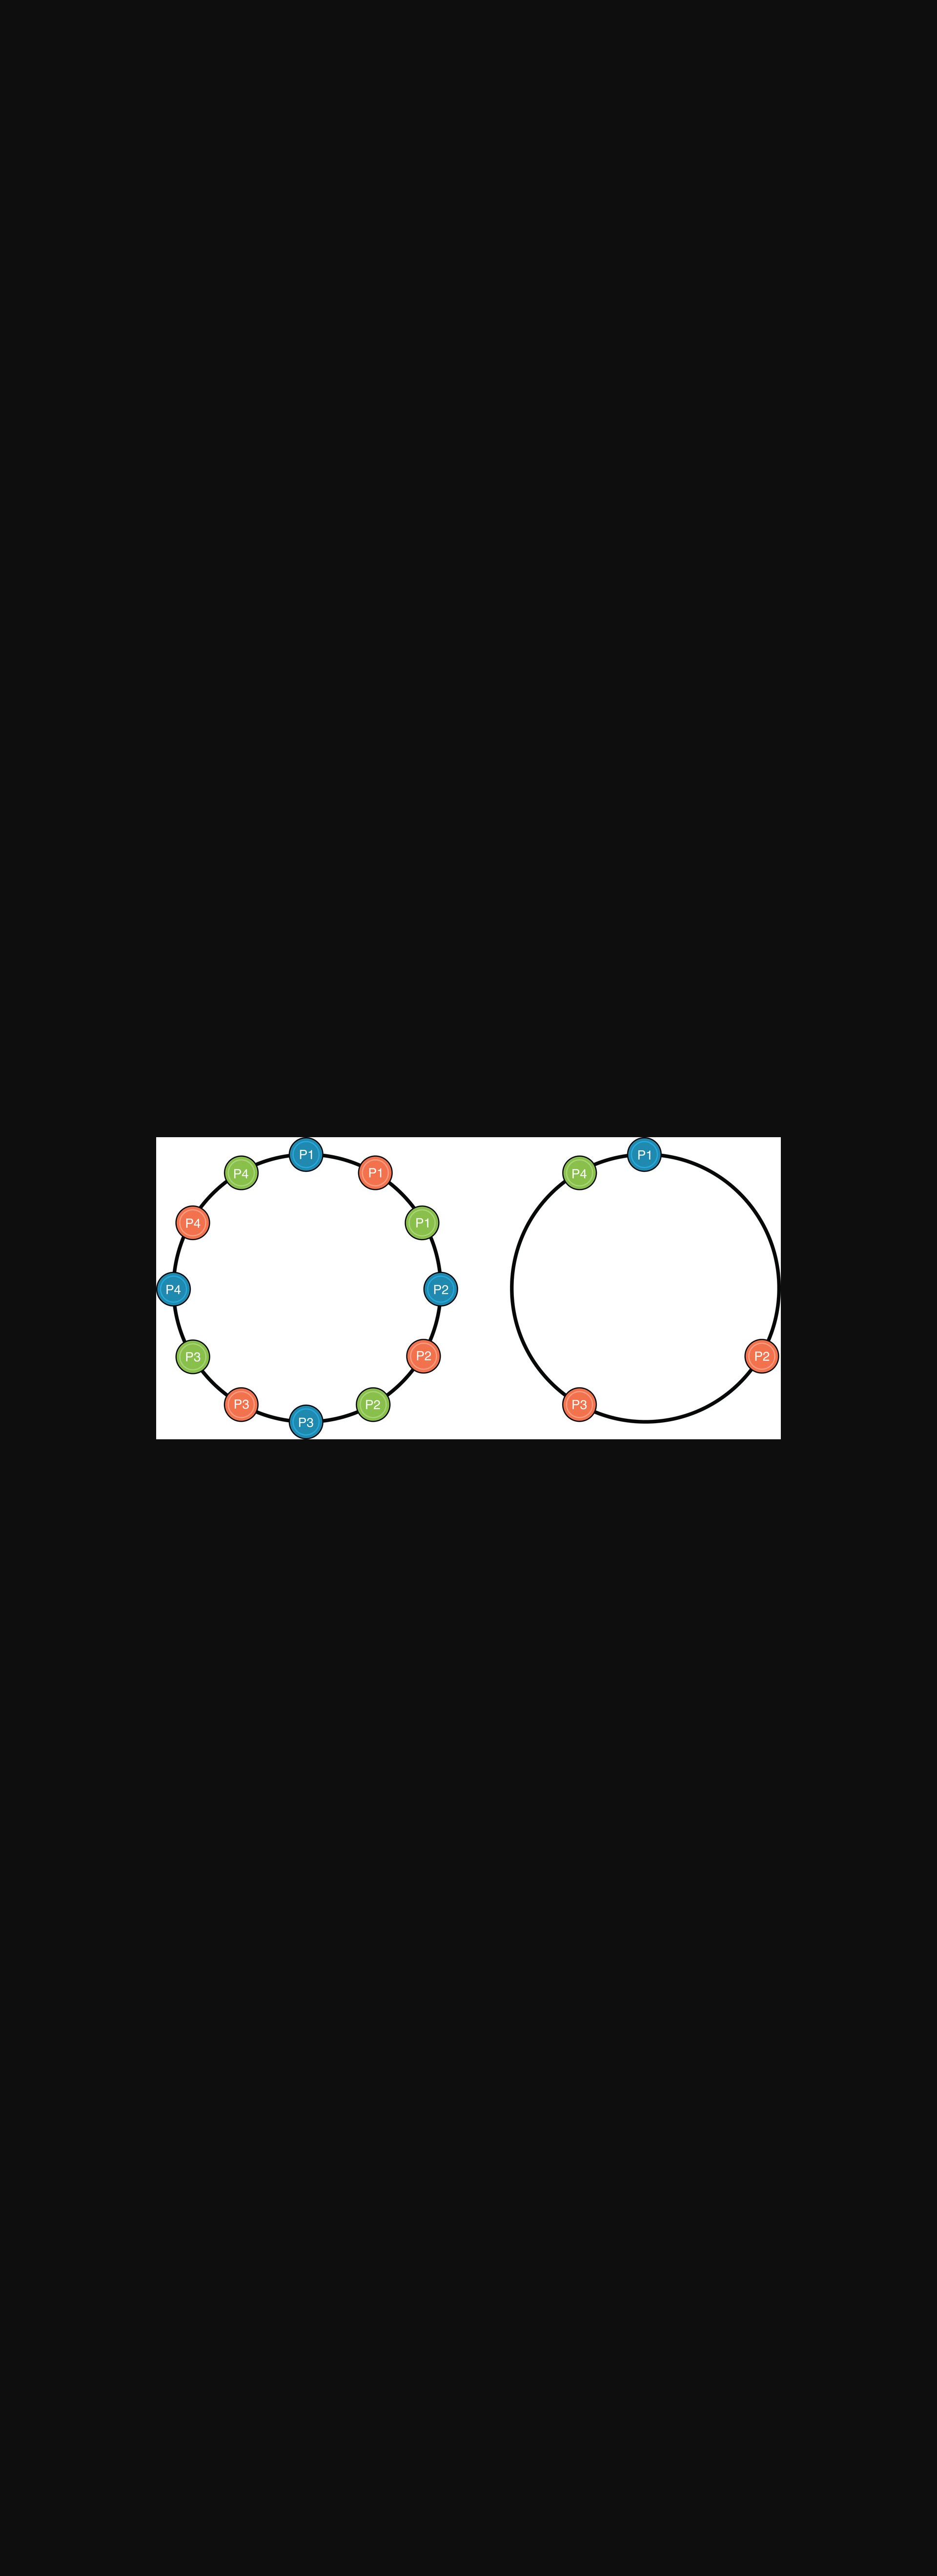

In [14]:
display(Image(driver.get_screenshot_as_png()))